# GRAPE calculation of control fields for bell state implementation

In [35]:
#required imports

%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
qutip.settings.auto_tidyup = False
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive, plot_grape_control_fields, _overlap

import warnings
warnings.filterwarnings("ignore")

In [38]:
#creating time steps for GRAPE


T = 2
times = np.linspace(0, T, 200)


In [4]:
#Define itterations and Hamiltonian Terms Grape can manipluate, in real life these are your control fields 
#qubit 1 is the pauli spin matrix tensored with the idenity matrix to make sure the dimensions are correct
#qubit 2 is the idenity tensors with the pauli spin matrix for the same reason

R = 100 # how many itterations GARPE does


H_ops = [# qubit 1: single-qubit control
         tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         # qubit 2: single-qubit control
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),

         ]

H_labels = [r'$u_{1x}$',
            r'$u_{1y}$',
            r'$u_{1z}$',
            
            r'$u_{2x}$',
            r'$u_{2y}$',
            r'$u_{2z}$',
            

        ]

In [5]:
# defining the drift hamiltonian

H1=tensor(sigmaz(), identity(2))
H2=tensor(identity(2), sigmaz())
H3=tensor(sigmaz(), sigmaz())


H0 = 0.3 * pi * (H1+H2+H3)
c_ops = []
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.82743339  0.          0.          0.        ]
 [ 0.         -0.9424778   0.          0.        ]
 [ 0.          0.         -0.9424778   0.        ]
 [ 0.          0.          0.         -0.9424778 ]]

In [39]:
# creating the input unitary tranfomation 

U=cnot()*tensor(hadamard_transform(),identity(2))
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.70710678  0.          0.70710678]
 [ 0.          0.70710678  0.         -0.70710678]
 [ 0.70710678  0.         -0.70710678  0.        ]]

# GRAPE

In [9]:
#creating initial control pulse values as starting guess for GRAPE


u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.01 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [10]:
#doing GRAPE using the cy_grape_unitary function built into qutip more info about it here:https://qutip.org/docs/3.1.0/modules/qutip/control/grape.html

result = cy_grape_unitary(U, H0, H_ops, R, times, phase_sensitive=False,
                          u_start=u0, progress_bar=TextProgressBar(),
                          eps=2*pi*5)

10.0%. Run time:  11.19s. Est. time left: 00:00:01:40
20.0%. Run time:  22.12s. Est. time left: 00:00:01:28
30.0%. Run time:  32.20s. Est. time left: 00:00:01:15
40.0%. Run time:  42.01s. Est. time left: 00:00:01:03
50.0%. Run time:  51.94s. Est. time left: 00:00:00:51
60.0%. Run time:  61.81s. Est. time left: 00:00:00:41
70.0%. Run time:  72.17s. Est. time left: 00:00:00:30
80.0%. Run time:  82.20s. Est. time left: 00:00:00:20
90.0%. Run time:  92.12s. Est. time left: 00:00:00:10
Total run time: 100.83s


## Plot control fields for the bell entangling gate in the presense of single-qubit tunnelling

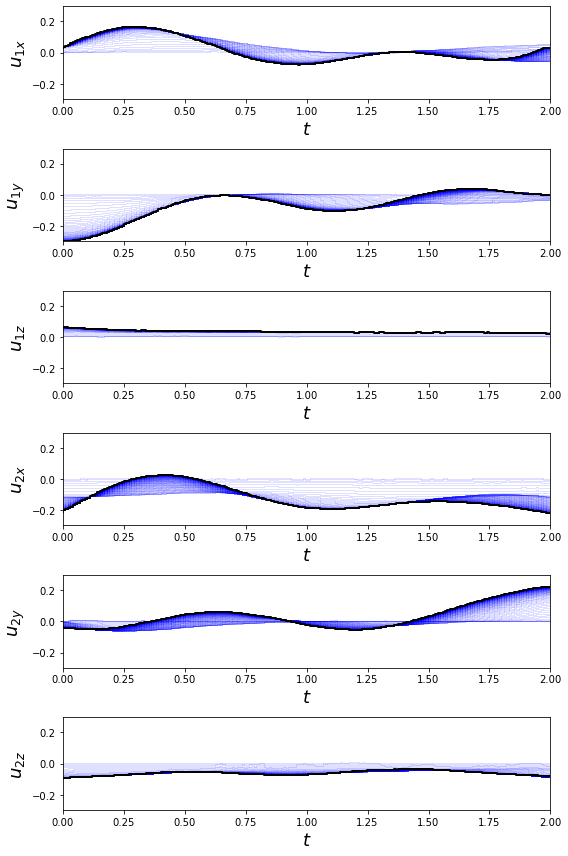

In [11]:
#Plotting pulse sqeuences from GRAPE


plot_grape_control_fields(times, result.u / (2 * pi), H_labels, uniform_axes=True);
plt.savefig("bellstatepluse.jpeg")

## Fidelity of the resutling GRAPE gate

In [26]:
#printing U_GRAPE

uf=result.U_f.tidyup(1e-1)
uf

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.50236147+0.49849827j  0.        +0.j          0.49720206+0.50180349j
   0.        +0.j        ]
 [ 0.        +0.j          0.49820293+0.50208579j  0.        +0.j
   0.50214532+0.49743169j]
 [ 0.        +0.j          0.4973605 +0.50221793j  0.        +0.j
  -0.50201197-0.49827588j]
 [ 0.50187646+0.49713097j  0.        +0.j         -0.49857118-0.50228785j
   0.        +0.j        ]]

## Quantum process tomography of the ideal and GRAPE gates for Bell state


In [16]:
#specify initial state to apply operator to, picked that both qubits were in fock state to begin

initialstate=tensor(basis(2, 0), basis(2, 0)) #initial state
initialstate


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [40]:
#ideal final state

idealfinalstate=U*initialstate
idealfinalstate

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]

In [28]:
#real final state

finalstate=uf*initialstate
finalstate

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.50236147+0.49849827j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.50187646+0.49713097j]]

In [31]:
#finding the density matrices so we can find the fidelity

idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(finalstate * finalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.50086757+0.j        0.        +0.j        0.        +0.j
  0.49994232+0.0004451j]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.49994232-0.0004451j 0.        +0.j        0.        +0.j
  0.49901918+0.j       ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.50086757+0.j        0.        +0.j        0.        +0.j
  0.49994232+0.0004451j]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.49994232-0.0004451j 0.        +0.j        0.        +0.j
  0.49901918+0.j       ]]


In [32]:
#printing fidelity
fidelity(idealdensitymatrix,densitymatrix)

0.9998867452386984

[[0.50086757+0.j        0.        +0.j        0.        +0.j
  0.49994232+0.0004451j]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.49994232-0.0004451j 0.        +0.j        0.        +0.j
  0.49901918+0.j       ]]


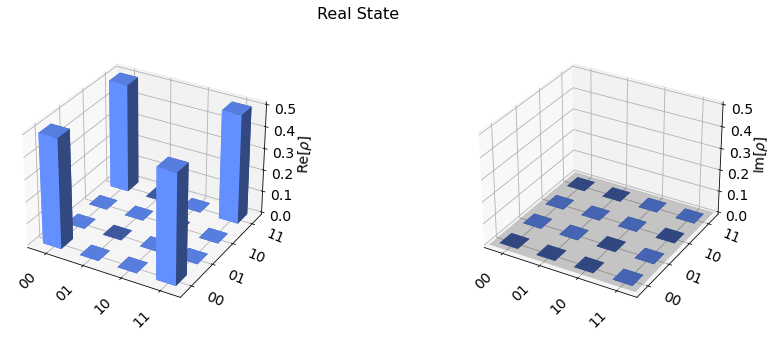

In [33]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='Real State')


[[0.50086757+0.j        0.        +0.j        0.        +0.j
  0.49994232+0.0004451j]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.49994232-0.0004451j 0.        +0.j        0.        +0.j
  0.49901918+0.j       ]]


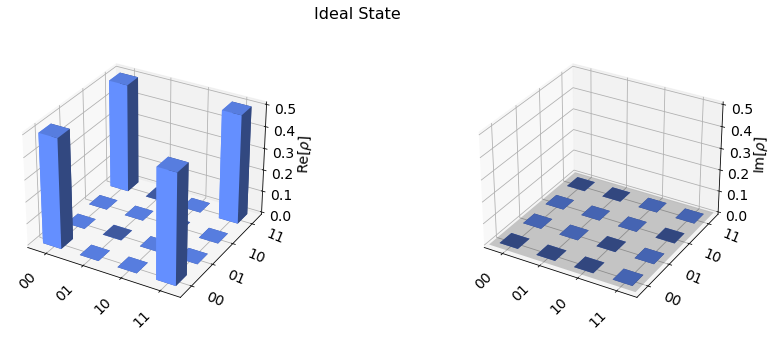

In [34]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='Ideal State')